<a href="https://colab.research.google.com/github/FKO78/OC-ds-p6/blob/main/P6_Cat%C3%A9gorisez_automatiquement_des_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install num2words
#!pip install unidecode

In [ ]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    return ' '.join(stmr.stem(lmtzr.lemmatize(w, get_wordnet_pos(w))) \
                    for w in tknzr.tokenize(col) \
                    if w not in sw and w.isalpha())

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols, sep=' '):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        #liste = list(itertools.chain.from_iterable(df[col].values))
        freq[col] = Counter(' '.join(df[col].values).split(sep)).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

# Chargement

In [ ]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding='utf-8', \
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())
cols = train.columns

print(train.info())

freq = recap_cols(train, cols[:-1]) 
freq = recap_cols(train, cols[-1:], '><') 

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 169828 to 1669645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None
Dénombrenent des mots
	Title  :  428791 dont  37244 distincts
	Body   : 7351899 dont 677338 distincts
Dénombrenent des mots
	Tags   :   95825 dont  39629 distincts


,Title,Body,Tags
169828,what are the real benefits of visual studio te...,<p>interested if anyone has used vsts database...,<sql-server><database-tools>
431644,how can i hook into the current formsauthentic...,<p>i've got an httpmodule in my application th...,<asp.net><events><forms-authentication><httpmo...
1450121,is there any sync algorithm/reference availabl...,<p>i'm planning to write a program to sync a f...,<algorithm><synchronization>
426609,how to assign profile values?,"<p>i don't know what i am missing, but i added...",<asp.net><asp.net-mvc><asp.net-membership><pro...
14646,"how to add ""project description"" in fogbugz?",<p>when i create a new project (or even when i...,<fogbugz>


# Nettoyage du dataframe

In [ ]:
# Stopwords nltk 
std_sw = set(nltk.corpus.stopwords.words('english')) 

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')

my_sw = std_sw.union(extra_sw)

tokenizer = nltk.RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*50)

for col in ['Title', 'Body']:
    if col == 'Body':
        # Convertion du html en chaine standard 
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()
        train[col] = train[col].apply(conv_html)
        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    # Tokenisation et suppression des stopwords
    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=std_sw, lmtzr=lemmatizer, stmr=stemmer)
    # Suppression des radicaux qui ne me semblent pas discriminants (ex. use, ...)
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() \
                                                      if w not in extra_sw]))
    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

# Reformatage des tags
print('Traitement des tags ', end='')
start_time = timeit.default_timer()
#train['Tags'] = train['Tags'].apply(lambda x: ' '.join(x[1:-1].split('><')))
# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split('><')))
elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

freq = recap_cols(train, cols)

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 51.1 sec
Conversion html de "Body" -> OK en 20.0 sec
Nettoyage/lemmatisation de "Body" -> OK en 4.01e+02 sec
Traitement des tags -> OK en 0.079 sec
Dénombrenent des mots
	Title  :  262233 dont  12585 distincts
	Body   : 2127877 dont  42544 distincts
	Tags   :  145824 dont  10494 distincts


,Title,Body,Tags,nTags
169828,real benefit visual studio team system databas...,interest anyon vst databas edit extens featur ...,sql-server database-tools,2
431644,hook current formsauthenticationmodul medium t...,httpmodul applic hook formsauthenticationmodul...,asp.net events forms-authentication httpmodule...,5
1450121,sync algorithm refer avail sync directori,plan write program sync folder real time acros...,algorithm synchronization,2
426609,assign profil valu,miss add profil properti web config file canno...,asp.net asp.net-mvc asp.net-membership profile,4
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1


In [ ]:
backup = train.copy()

## Explorations des tags

In [ ]:
top = 50

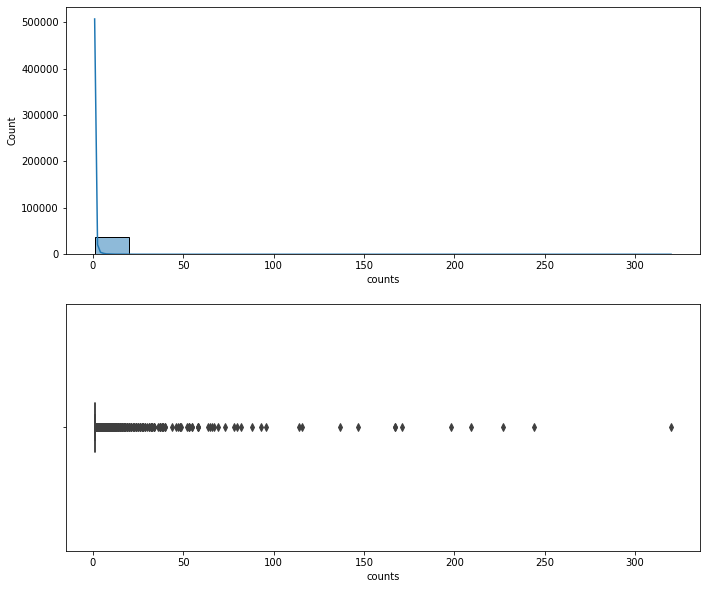

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(222)
sns.histplot(temp.counts, kde=True)
plt.subplot(224)
sns.boxplot(x=temp.counts, width=0.2)

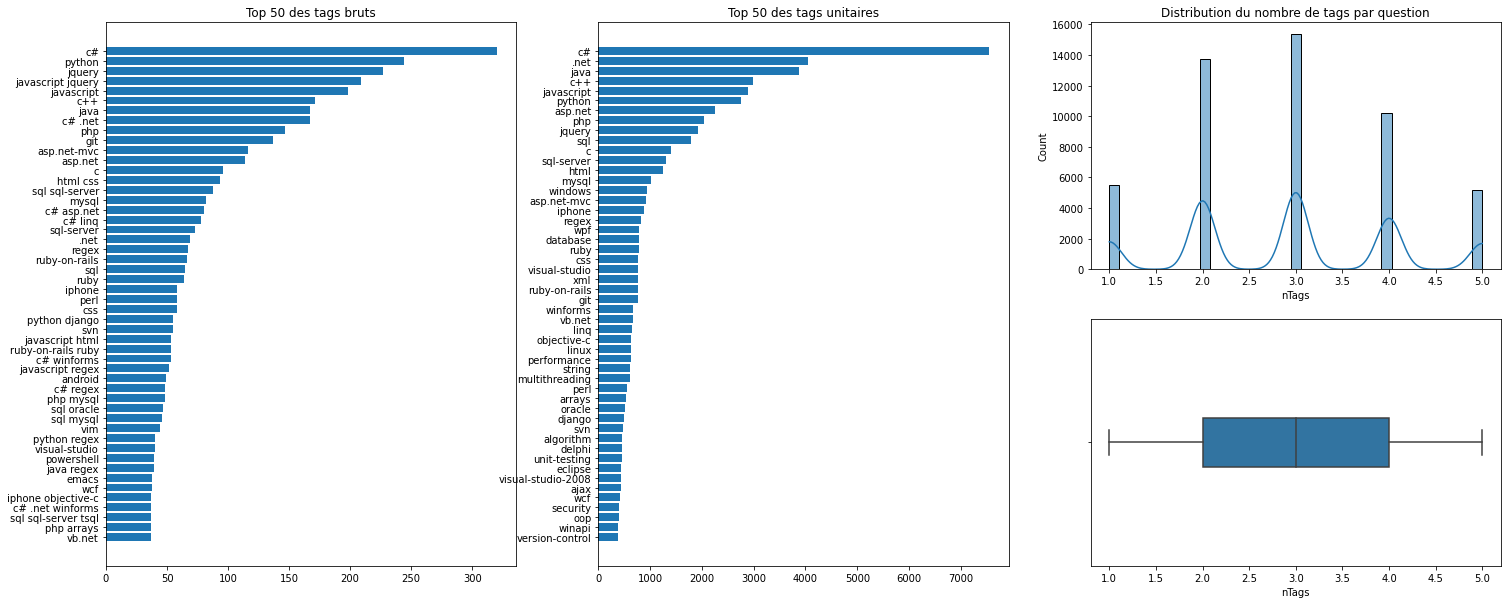

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
temp = train.Tags.value_counts().to_frame('counts')
plt.barh(temp.sort_values(by='counts', ascending=True)[-top:].index, 
         temp.sort_values(by='counts', ascending=True)[-top:].counts)
plt.title('Top {} des tags bruts'.format(top))

plt.subplot(132)
plt.barh([k for k, v in sorted(freq['Tags'][:top], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:top], key=lambda x: x[1])])
plt.title('Top {} des tags unitaires'.format(top))

temp = pd.DataFrame.from_dict(dict(freq['Tags'][:50]), orient='index')\
                              .rename(columns={0:'counts'})
fig = plt.figure(figsize=(25, 10))
plt.subplot(222)
plt.title('Distribution du nombre de tags')
sns.histplot(temp.counts, kde=True)
plt.subplot(224)
sns.boxplot(x=temp.counts, width=0.2)

plt.subplot(233)
sns.histplot(train['nTags'], kde=True)
plt.title('Distribution du nombre de tags par question')

plt.subplot(236)
sns.boxplot(x=train['nTags'], width=0.2)

In [ ]:
temp.describe()

,counts
count,10494.000000
mean,13.895941
std,121.763098
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,7544.000000


Text(0.5, 1.0, 'Distribution du nombre de tags par question')

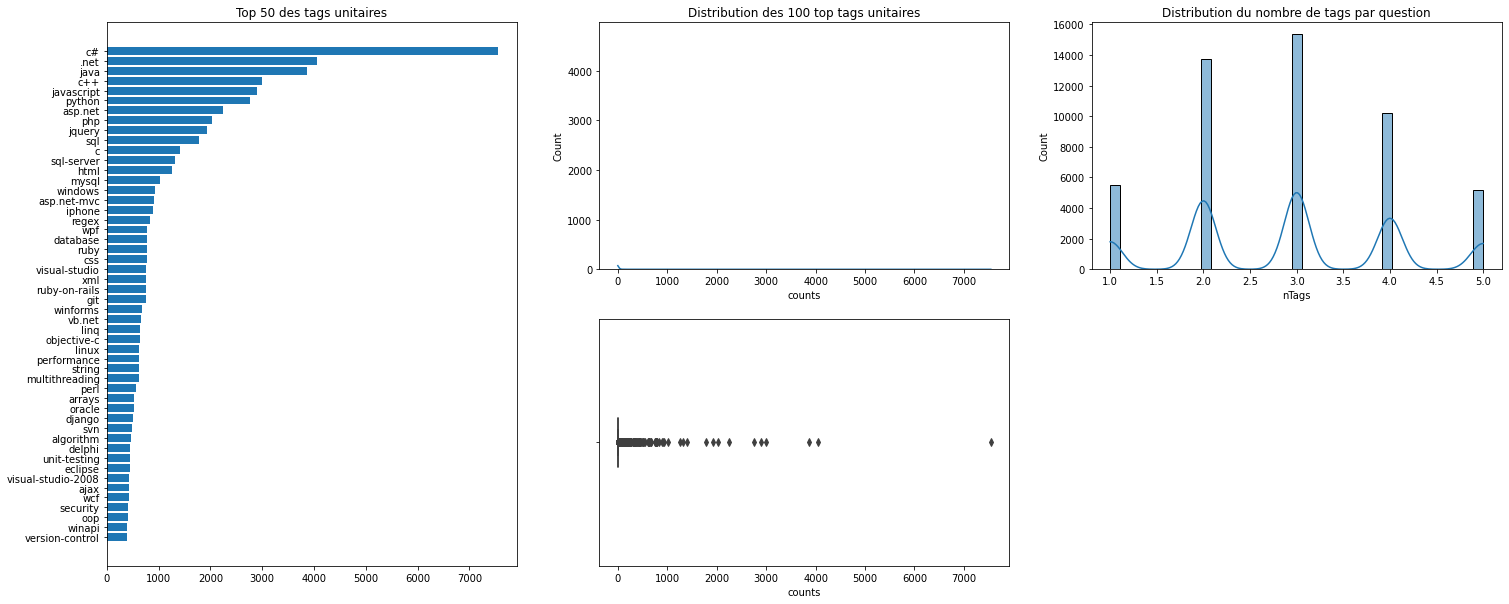

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['Tags'][:top], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:top], key=lambda x: x[1])])
plt.title('Top {} des tags unitaires'.format(top))

temp = pd.DataFrame.from_dict(dict(freq['Tags']), orient='index')\
                              .rename(columns={0:'counts'})
plt.subplot(232)
plt.title('Distribution des 100 top tags unitaires')
sns.histplot(temp.counts, kde=True)
plt.subplot(235)
sns.boxplot(x=temp.counts, width=0.2)

plt.subplot(233)
sns.histplot(train['nTags'], kde=True)
plt.title('Distribution du nombre de tags par question')

In [ ]:
temp.describe()

,counts
count,50.000000
mean,1184.340000
std,1278.520839
min,380.000000
25%,505.500000
50%,759.500000
75%,1193.000000
max,7544.000000


## Etiquetage des tags bruts

In [ ]:
lbl = LabelEncoder()
train['Tags_lbl'] = lbl.fit_transform(train.Tags)
train.head()

,Title,Body,Tags,nTags,Tags_lbl
169828,real benefit visual studio team system databas...,interest anyon vst databas edit extens featur ...,sql-server database-tools,2,32931
431644,hook current formsauthenticationmodul medium t...,httpmodul applic hook formsauthenticationmodul...,asp.net events forms-authentication httpmodule...,5,3047
1450121,sync algorithm refer avail sync directori,plan write program sync folder real time acros...,algorithm synchronization,2,2067
426609,assign profil valu,miss add profil properti web config file canno...,asp.net asp.net-mvc asp.net-membership profile,4,2824
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1,15657


In [ ]:
dict_tags = defaultdict(list)

#temp = train[train.index.isin([169828, 431644, 1450121, 426609, 14646])].copy()
temp = train.copy()

for i, j in temp.iterrows():
    for t in j['Tags'].split():
        if t in dict(freq['Tags'][:100]).keys():
            try:
                dict_tags[t].extend([i])
            except KeyError:
                dict_tags[t] = [i]

for k, v in dict_tags.items():
    chaine = ' '.join(temp[temp.index.isin(v)].Title.values + temp[temp.index.isin(v)].Body.values )
    dict_tags[k] = Counter(chaine.split()).most_common()[:2]

dict_tags

defaultdict(list,
            {'.net': [('net', 3146), ('code', 1849)],
             '.net-3.5': [('net', 231), ('work', 87)],
             'ajax': [('ajax', 691), ('page', 359)],
             'algorithm': [('algorithm', 513), ('number', 268)],
             'android': [('android', 454), ('app', 177)],
             'arrays': [('array', 1479), ('valu', 267)],
             'asp.net': [('net', 2613), ('asp', 2424)],
             'asp.net-mvc': [('mvc', 1222), ('net', 1152)],
             'bash': [('file', 438), ('script', 436)],
             'c': [('c', 2036), ('code', 921)],
             'c#': [('c', 4935), ('code', 4025)],
             'c++': [('c', 3621), ('code', 1738)],
             'class': [('class', 765), ('method', 131)],
             'cocoa': [('object', 155), ('cocoa', 134)],
             'cocoa-touch': [('view', 204), ('iphon', 128)],
             'css': [('cs', 1039), ('div', 459)],
             'database': [('databas', 1282), ('tabl', 989)],
             'database-design': [(

In [ ]:
dict2_tags = defaultdict(list)

temp = train.copy()

for i, j in temp.iterrows():
    for t in j['Tags'].split():
        if t in dict(freq['Tags'][:100]).keys():
            try:
                dict_tags[t].extend([i])
            except KeyError:
                dict_tags[t] = [i]

for k, v in dict_tags.items():
    chaine = ' '.join(temp[temp.index.isin(v)].Title.values + temp[temp.index.isin(v)].Body.values )
    dict_tags[k] = Counter(chaine.split()).most_common()[:2]

dict_tags

defaultdict(list,
            {'.net': [('net', 3146), ('code', 1849)],
             '.net-3.5': [('net', 231), ('work', 87)],
             'ajax': [('ajax', 691), ('page', 359)],
             'algorithm': [('algorithm', 513), ('number', 268)],
             'android': [('android', 454), ('app', 177)],
             'arrays': [('array', 1479), ('valu', 267)],
             'asp.net': [('net', 2613), ('asp', 2424)],
             'asp.net-mvc': [('mvc', 1222), ('net', 1152)],
             'bash': [('file', 438), ('script', 436)],
             'c': [('c', 2036), ('code', 921)],
             'c#': [('c', 4935), ('code', 4025)],
             'c++': [('c', 3621), ('code', 1738)],
             'class': [('class', 765), ('method', 131)],
             'cocoa': [('object', 155), ('cocoa', 134)],
             'cocoa-touch': [('view', 204), ('iphon', 128)],
             'css': [('cs', 1039), ('div', 459)],
             'database': [('databas', 1282), ('tabl', 989)],
             'database-design': [(

# Réduction du scope
Pour commencer, je considère les questions avec 1 seul tag 

In [ ]:
train_1T = train[train.nTags == 1]
freq = recap_cols(train_1T, cols)
print(train.shape)
train_1T.head()

Dénombrenent des mots
	Title  :   27668 dont   3747 distincts
	Body   :  190725 dont   9809 distincts
	Tags   :    5512 dont    867 distincts
(50000, 4)


,Title,Body,Tags,nTags
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1
34017938,decrement valu scheme,procedur find n small prime larg add paramet n...,scheme,1
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1


Réduction aux 50 top tags

Dénombrenent des mots
	Title  :   15180 dont   2316 distincts
	Body   :   97056 dont   6340 distincts
	Tags   :    3009 dont     34 distincts


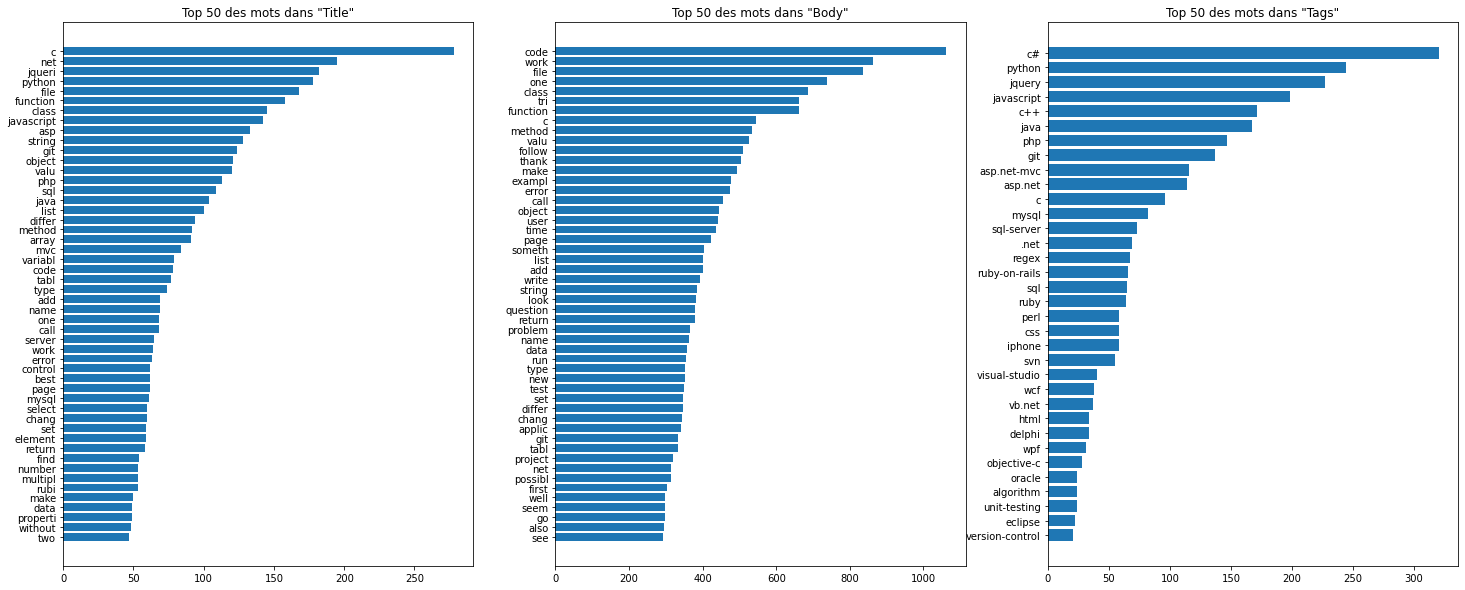

In [ ]:
cpt = 1
train_1T = train_1T[train_1T.Tags.isin(dict(freq['Tags'][:top]).keys())]

freq = recap_cols(train_1T, cols)

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:top], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:top], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(top, col))
    cpt += 1 

# TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\w+')

## Focus Title

In [ ]:
tfidf_Title_v = tfidf_vectorizer.fit_transform(train_1T['Title'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Title = pd.DataFrame(tfidf_Title_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Title.head()

,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,admin,advantag,advic,affect,age,aggreg,ago,...,widget,width,wildcard,win,window,winform,within,without,withouth,wizard,woe,word,work,workaround,workbook,worker,world,worth,wpf,wrap,writabl,write,writeabl,writefil,writeln,wrong,wysiwyg,xhtml,xml,xp,ye,year,yet,yield,zehut,zero,zip,ziparch,zoom,ß
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.347054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1087251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1197,mean,0.760171
1736,rubi,0.649723
1545,produc,0.000000
1539,privileg,0.000000
1540,pro,0.000000
...,...,...
772,forbidden,0.000000
773,forc,0.000000
774,foreach,0.000000
775,foreign,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1
1087251,simpl html construct asp net,simpl question think put tag asp net app ask m...,asp.net,1


### PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Title.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00215878 0.00198559] 0.004144369675533617


### Clustering

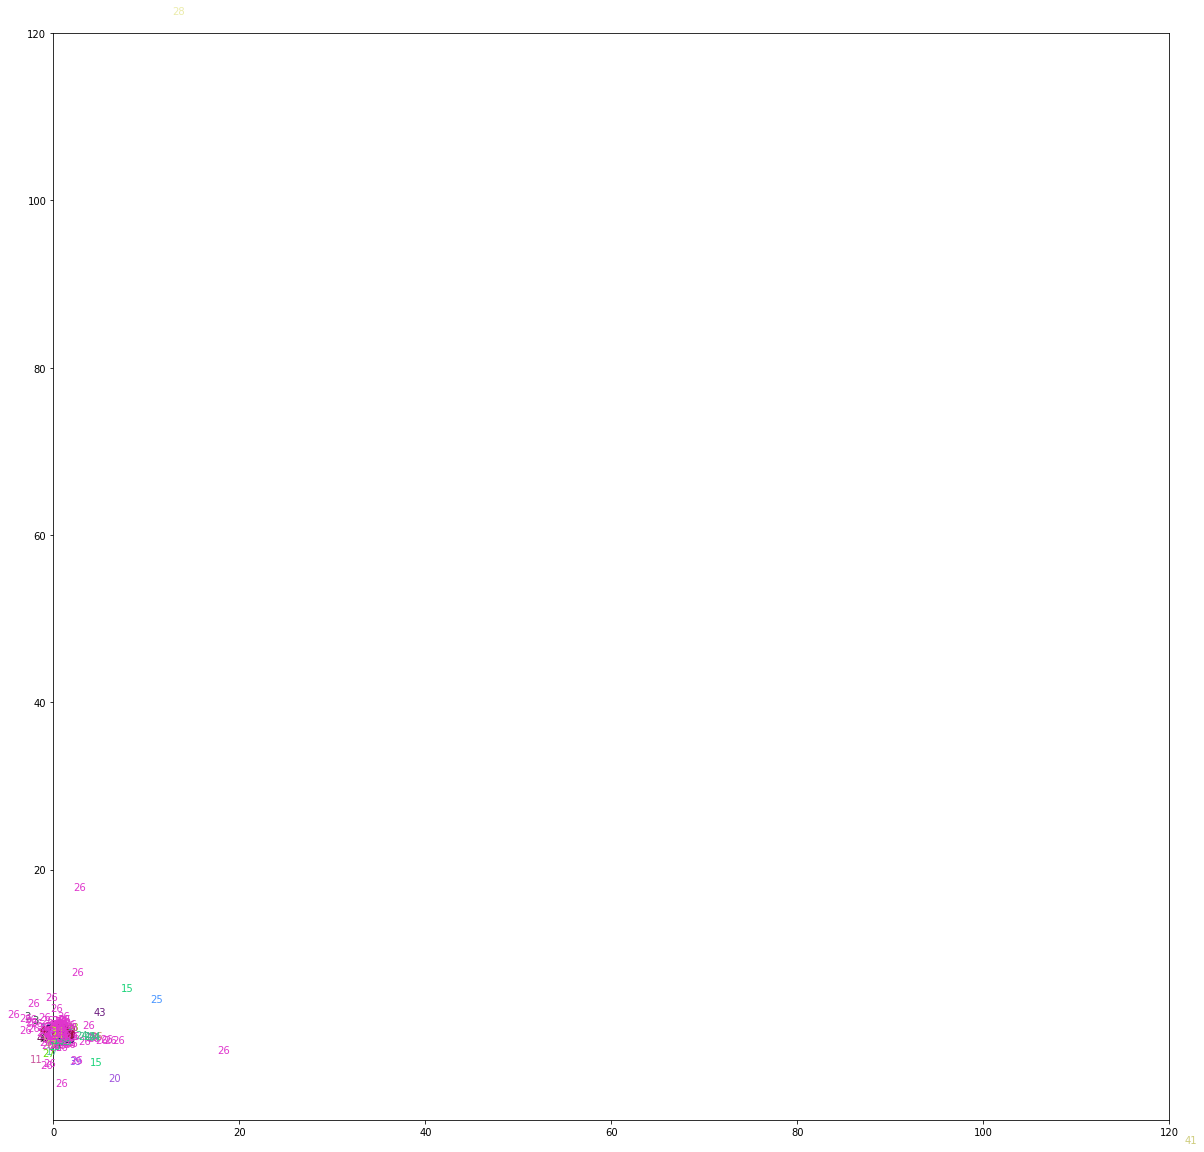

Silhouette Coefficient: -0.039


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,7,1,51,1,1,1,1,1,31,1,47,1,45,20,163,1,1,1,1,1,1,7,45,6,1,2886,1,1,7,1,1,1,1,1,1,1,1,1,1,88,1,1,1,2,1,41,1,1,1


### Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Title, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 2538), (1045, 2538))

accuracy 65.00% time 3.14s

Confusion matrix, without normalization


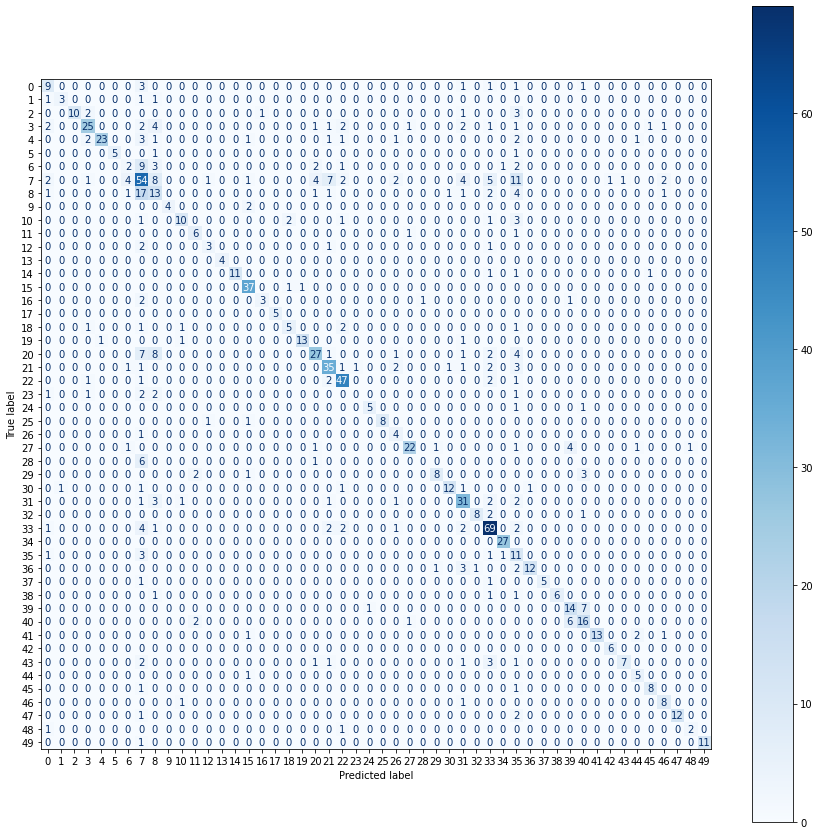

Normalized confusion matrix


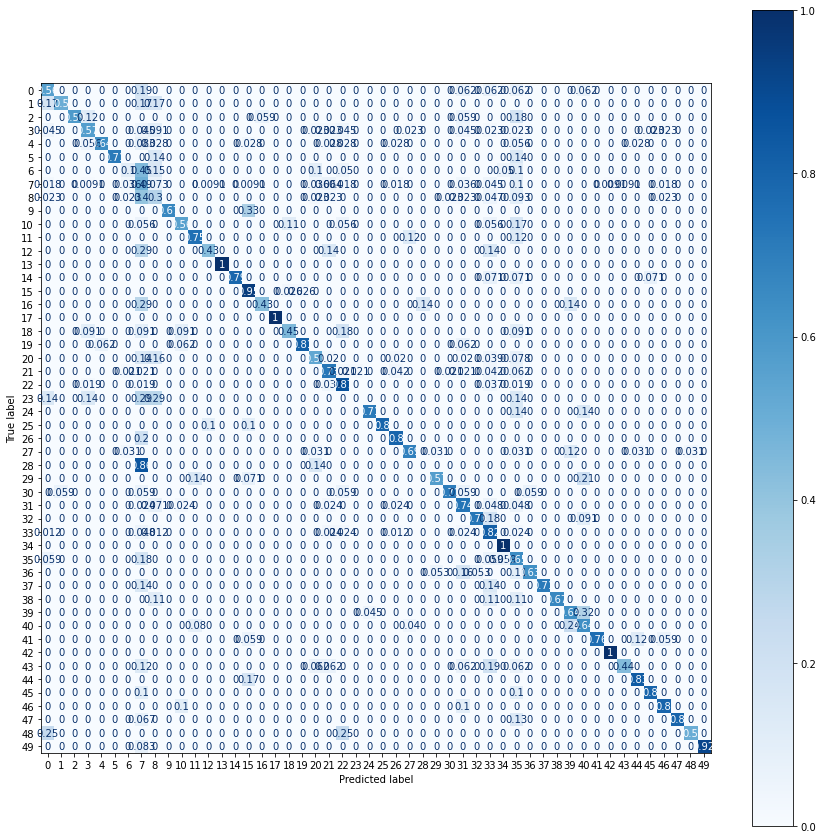

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

## Focus Body

In [ ]:
from unidecode import unidecode

In [ ]:
train_1T['Body'] = train_1T['Body'].apply(unidecode)

In [ ]:
tfidf_Body_v = tfidf_vectorizer.fit_transform(train_1T['Body'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Body = pd.DataFrame(tfidf_Body_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Body.head()

,a,ab,abandon,abbrevi,abbyy,abc,abcd,abcdefghi,abil,abl,abnorm,abort,aboutm,abovement,absenc,absolut,abstract,absurd,abt,abus,ac,academ,academi,acccess,accdb,accent,accept,acces,access,accessor,accid,accident,accommod,accompani,accomplish,accord,accordingli,account,accountcontrol,accountmanag,...,xxxxxxxxxx,y,ya,yaaq,yahoo,yahtze,yaml,yank,yay,ye,yeah,year,yearli,yellow,yesterday,yet,yield,yike,yolk,york,young,youtub,yu,yy,zc,zed,zehut,zeppelin,zero,zf,zi,zijab,zip,ziparch,zone,zoom,zope,zqw,zsh,zubair
1023055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'ß'.isalpha()

True

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1311,mean,0.750079
1904,rubi,0.661349
1695,pro,0.000000
1688,primit,0.000000
1689,princip,0.000000
...,...,...
847,fork,0.000000
848,forloop,0.000000
849,form,0.000000
850,format,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Body.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0. 0.] 0.0036313742918188284


Clustering

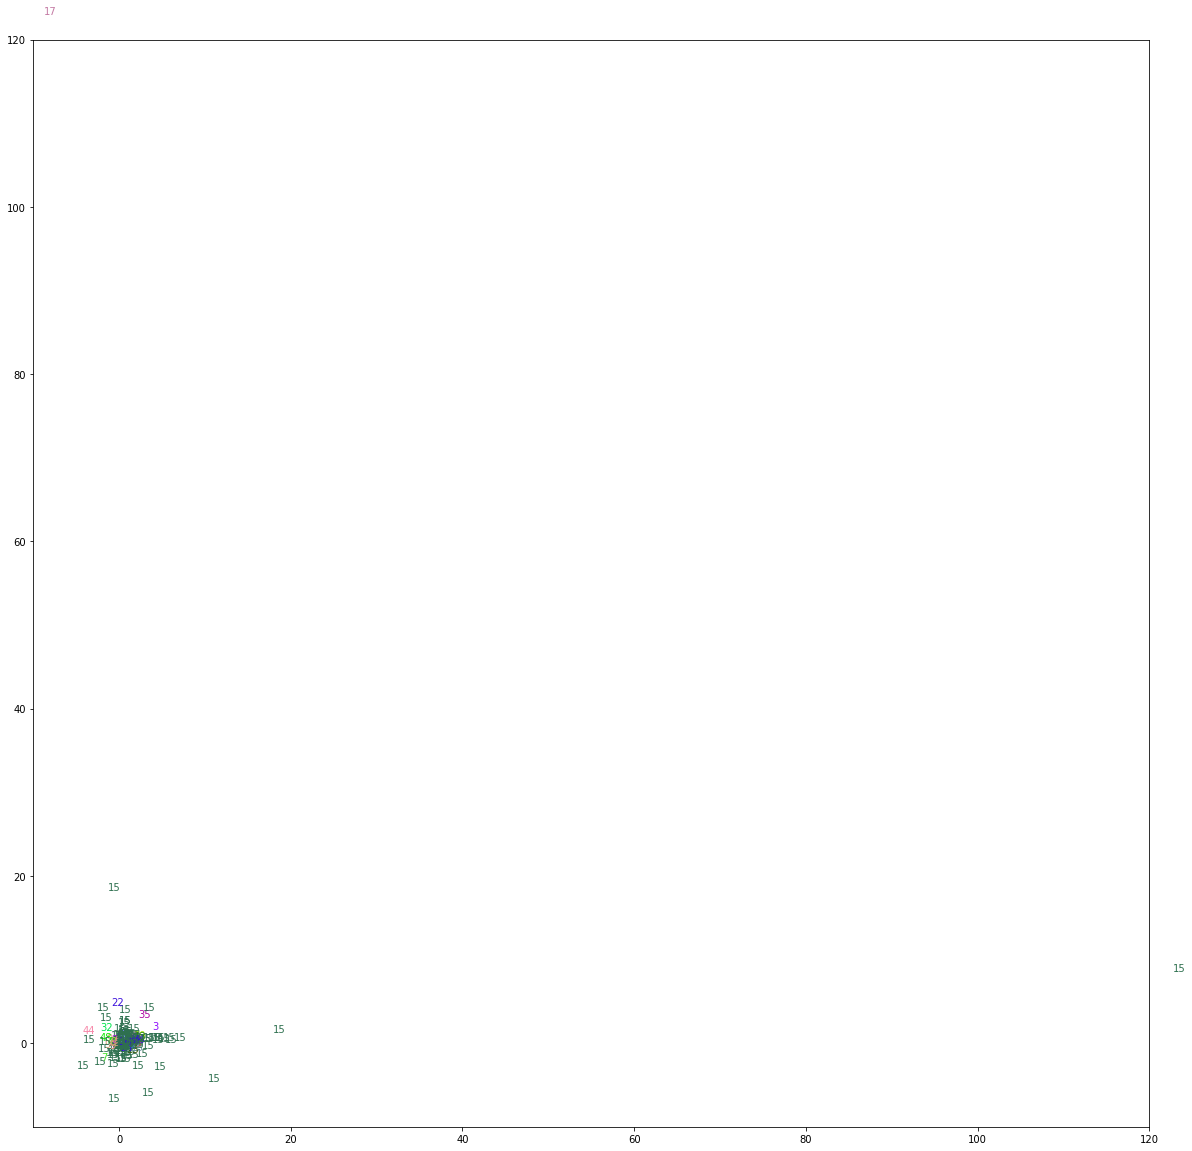

Silhouette Coefficient: -0.041


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,3,10,43,1,1,1,1,1,1,38,12,1,1,1,8,2914,1,1,1,1,1,1,1,1,329,1,1,1,1,1,1,1,1,1,64,1,1,1,1,1,1,1,1,1,1,1,1,1,20,1


Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Body, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 7045), (1045, 7045))

accuracy 64.00% time 3.30s

Confusion matrix, without normalization


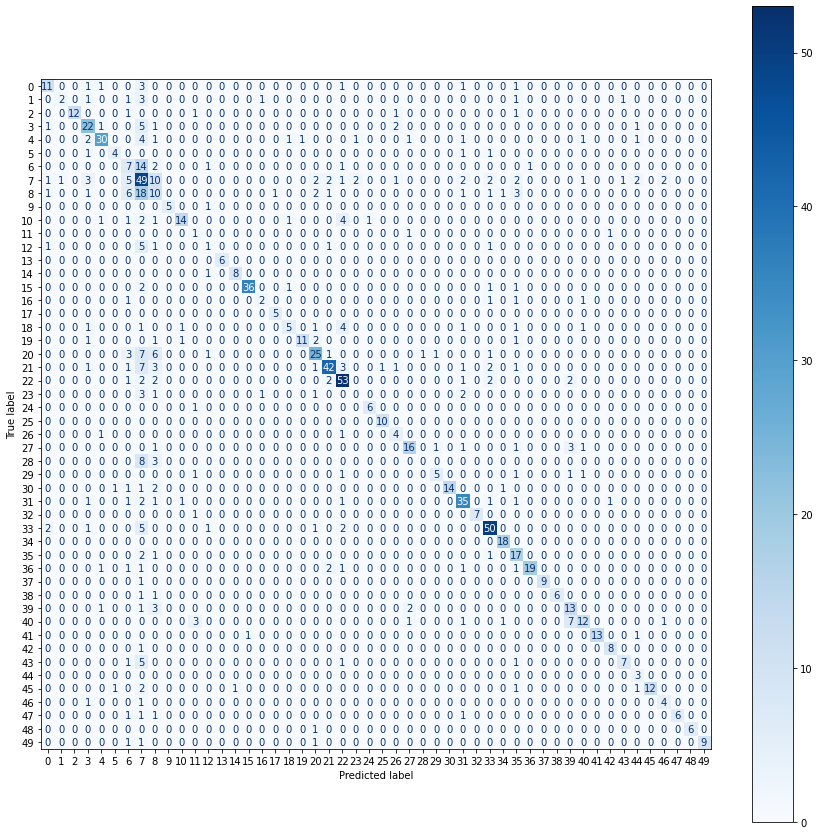

Normalized confusion matrix


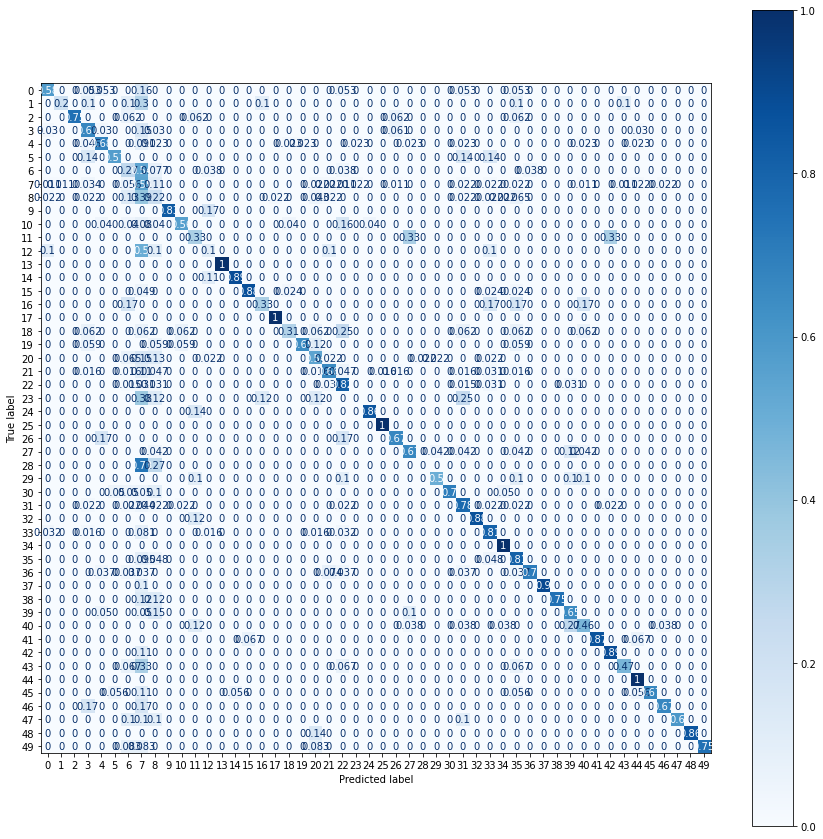

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

# TF-IDF new

In [ ]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\w+')

NameError: ignored

## Focus Title

In [ ]:
tfidf_Title_v = tfidf_vectorizer.fit_transform(train['Title'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Title = pd.DataFrame(tfidf_Title_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Title.head()

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1197,mean,0.760171
1736,rubi,0.649723
1545,produc,0.000000
1539,privileg,0.000000
1540,pro,0.000000
...,...,...
772,forbidden,0.000000
773,forc,0.000000
774,foreach,0.000000
775,foreign,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1
1087251,simpl html construct asp net,simpl question think put tag asp net app ask m...,asp.net,1


### PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Title.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00215878 0.00198559] 0.004144369675533617


### Clustering

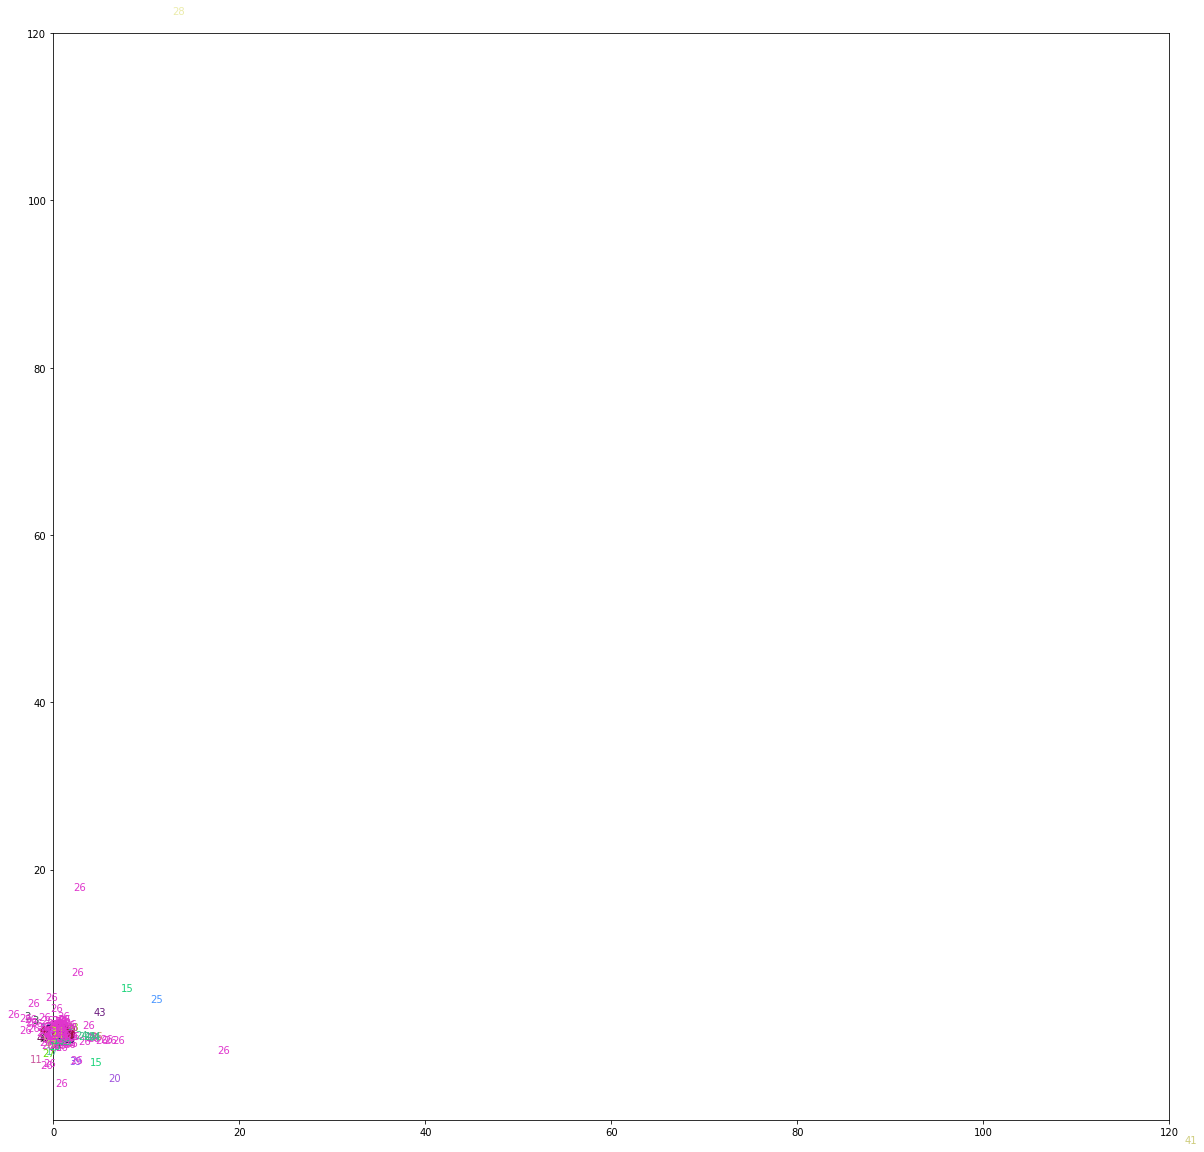

Silhouette Coefficient: -0.039


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,7,1,51,1,1,1,1,1,31,1,47,1,45,20,163,1,1,1,1,1,1,7,45,6,1,2886,1,1,7,1,1,1,1,1,1,1,1,1,1,88,1,1,1,2,1,41,1,1,1


### Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Title, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 2538), (1045, 2538))

accuracy 65.00% time 3.14s

Confusion matrix, without normalization


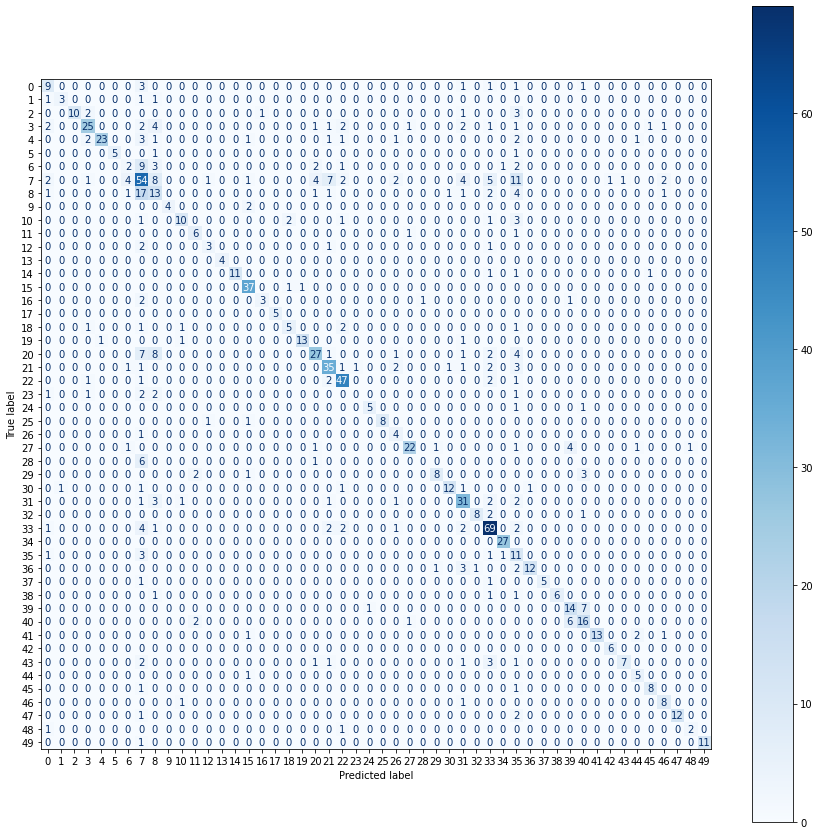

Normalized confusion matrix


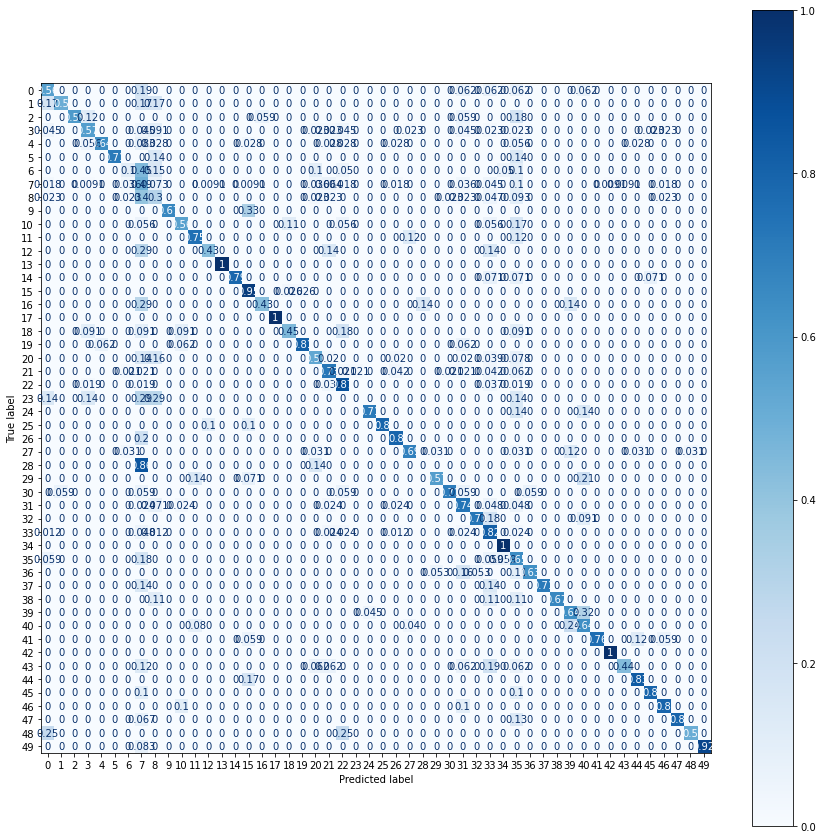

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

## Focus Body

In [ ]:
from unidecode import unidecode

In [ ]:
train_1T['Body'] = train_1T['Body'].apply(unidecode)

In [ ]:
tfidf_Body_v = tfidf_vectorizer.fit_transform(train_1T['Body'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Body = pd.DataFrame(tfidf_Body_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Body.head()

,a,ab,abandon,abbrevi,abbyy,abc,abcd,abcdefghi,abil,abl,abnorm,abort,aboutm,abovement,absenc,absolut,abstract,absurd,abt,abus,ac,academ,academi,acccess,accdb,accent,accept,acces,access,accessor,accid,accident,accommod,accompani,accomplish,accord,accordingli,account,accountcontrol,accountmanag,...,xxxxxxxxxx,y,ya,yaaq,yahoo,yahtze,yaml,yank,yay,ye,yeah,year,yearli,yellow,yesterday,yet,yield,yike,yolk,york,young,youtub,yu,yy,zc,zed,zehut,zeppelin,zero,zf,zi,zijab,zip,ziparch,zone,zoom,zope,zqw,zsh,zubair
1023055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'ß'.isalpha()

True

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1311,mean,0.750079
1904,rubi,0.661349
1695,pro,0.000000
1688,primit,0.000000
1689,princip,0.000000
...,...,...
847,fork,0.000000
848,forloop,0.000000
849,form,0.000000
850,format,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Body.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0. 0.] 0.0036313742918188284


Clustering

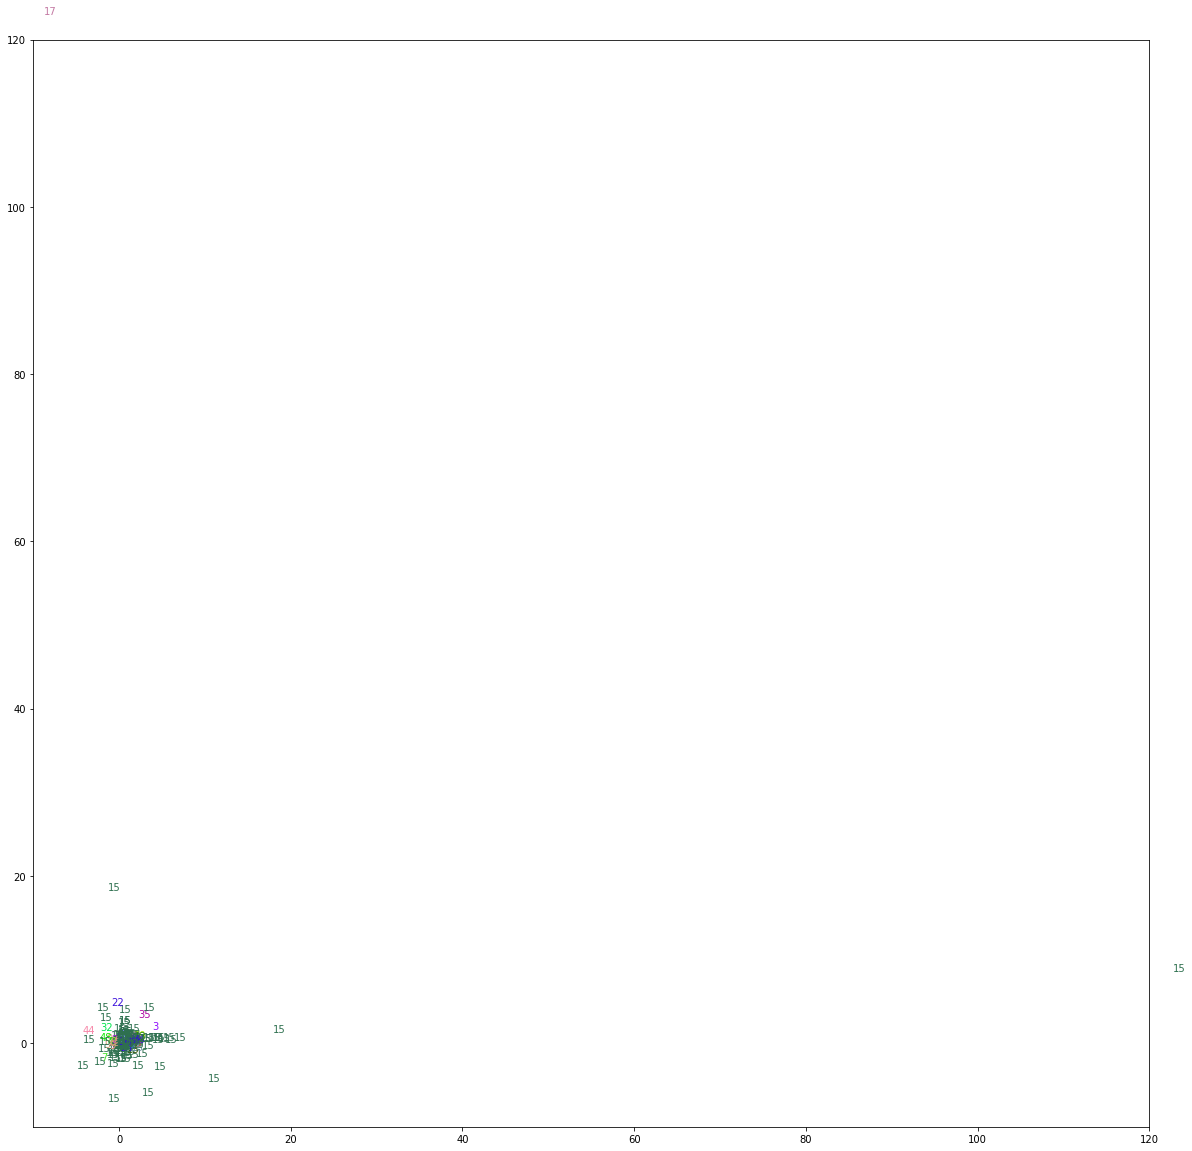

Silhouette Coefficient: -0.041


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,3,10,43,1,1,1,1,1,1,38,12,1,1,1,8,2914,1,1,1,1,1,1,1,1,329,1,1,1,1,1,1,1,1,1,64,1,1,1,1,1,1,1,1,1,1,1,1,1,20,1


Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Body, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 7045), (1045, 7045))

accuracy 64.00% time 3.30s

Confusion matrix, without normalization


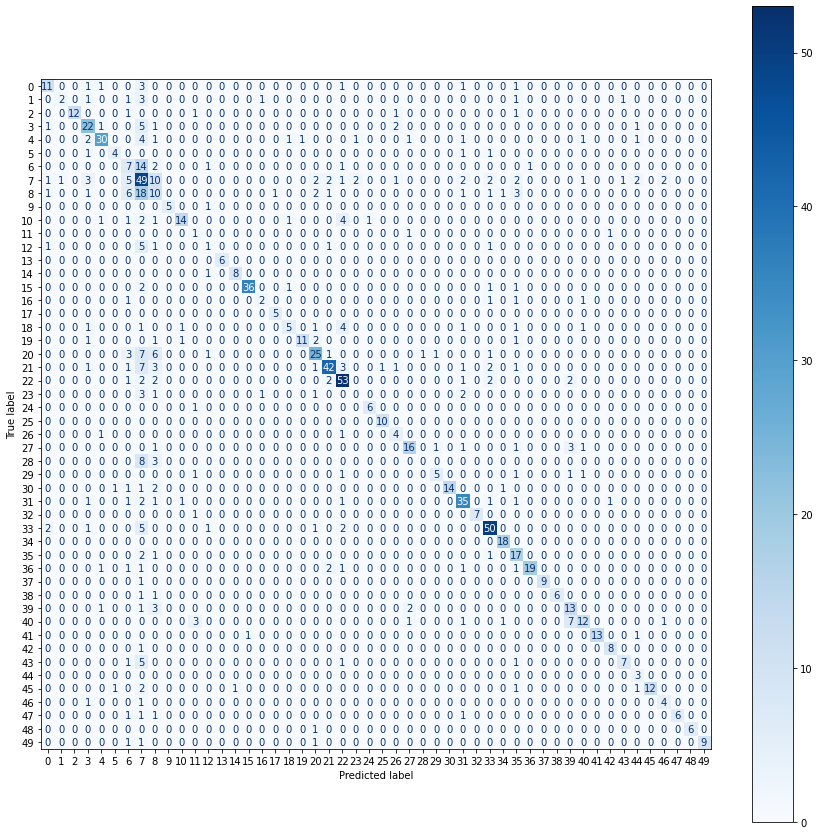

Normalized confusion matrix


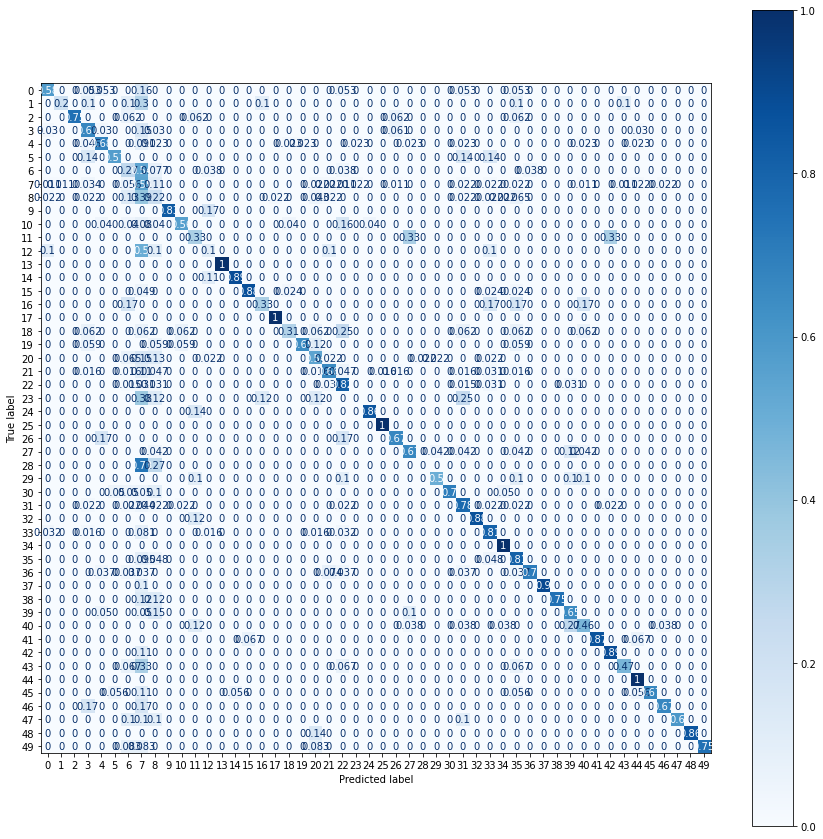

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

# LDA

In [ ]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
TF_Title=cv.fit_transform(train_1T.Title)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 50

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(TF_Title)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=50, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tfidf.columns[:-1], no_top_words)

Topic 0:
tripl ror printf statu newcom integr rule megabyt tail cart
Topic 1:
getrespons shadow fnc comprehens proper protect raw multipli fieldnam namespac
Topic 2:
euler compareto transit dst arraylist mozilla isv updat loop stringparam
Topic 3:
watch collaps system freelanc seri grandpar significantli recommend optimis winform
Topic 4:
verticalalign stringbuild procedur verbos input cocoa round look dealloc erb
Topic 5:
mercuri roll cl default smoothli mixin multipl other roundup eula
Topic 6:
android worker tamper placeholderpagetitleintitlearea collect signific miss version back somefunc
Topic 7:
name asp multi resourc applic eval vb continu valueof action
Topic 8:
teach ifoo reload commun dimension drive initialzi enablecontrol layer trigger
Topic 9:
storabl isv array chanukah besid perform overkil host nativ concret
Topic 10:
jre execut urg overwrit dialogprefer cr usag dialog preprocessor scrap
Topic 11:
screenshot javascript cheat riddl urg squash onto hundr firebug ispostback